# VANILLA GAN

## Imports libraries for the GAN model

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from numpy.random import randn
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 )
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train)
cifar10_test = tfds.as_numpy(cifar10_test)

# Seperate feature X and label Y
X_train, y_train = cifar10_train["image"], cifar10_train["label"]
X_test, y_test = cifar10_test["image"], cifar10_test["label"]

# Print shapes of the entire training and test set of CIFAR 10
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

In [ ]:
# Get samples  of a certain label
label = 0 # Class '1' is car. You may change this label to another class label.
train_indices = np.where(y_train == label) # Get indices of the label
train_set = X_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = X_train[test_indices] # Get test samples of the label

# Print shapes of datasets of the selected class
print("train_set shape of the selected class: " + str(train_set.shape))


# NOTE: training a GAN does not require to have train/test split. All data samples of the training and the test set are used as real data samples.
# You should merge the training and the test set to get more real data samples, i.e., merge the train_set and the test_set to one dataset which is the real dataset.
# Merge the train and test sets
airplane_train_images = np.concatenate((train_set, test_set), axis=0)
airplane_train_images = airplane_train_images.astype(np.float32)
airplane_train_images = (airplane_train_images - 127.5) / 127.5

print("train_set shape of the selected class after merging: " + str(airplane_train_images.shape))

In [ ]:
# Visualize some data samples of class '0' (plane)
import matplotlib.pyplot as plt
imgplot = plt.imshow(airplane_train_images[0])
plt.show()
imgplot = plt.imshow(airplane_train_images[1])
plt.show()
imgplot = plt.imshow(airplane_train_images[3])
plt.show()
imgplot = plt.imshow(airplane_train_images[4])
plt.show()

Plotting fake images. This will be used to visualize sample outputs from the GAN while it is being trained.

In [ ]:
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Creating batches of the train images so it can be fed to the model while training.

In [ ]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(airplane_train_images).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Build the Model

Creating the two main parts of the GAN:
* generator - creates the fake data
* discriminator - determines if an image is fake or real

### Discriminator

The discriminator takes in the input (fake or real) images and determines if it is fake or not. Thus, the input shape will be that of the training images.

In [ ]:
def discriminator_nn(in_shape=(32,32,3)):
	model = Sequential()

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

discriminator = discriminator_nn()
print(discriminator.summary())

### Generator

The generator takes in random noise and uses it to create fake images.

In [ ]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point.
  #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
  #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector.
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model.

latent_dim =  100
generator = define_generator(latent_dim)
print(generator.summary())

Sampling output of an untrained generator. This will be just random points. After training, these will resemble digits from the dataset

In [ ]:
# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# generate points in latent space as input for the generator
latent_points = generate_latent_points(latent_dim, 32)

# Generate a batch of noise input (batch size = 16)
#test_noise = tf.random.normal([16, latent_dim])

# Feed the batch to the untrained generator
test_image = generator(latent_points)

def plot_fake_images(fake_images, n_cols=4):
    n_rows = (len(fake_images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    for index, image in enumerate(fake_images):
        plt.subplot(n_rows, n_cols, index + 1)
        # Rescale pixel values from [-1, 1] to [0, 1] for proper display
        image = (image + 1) / 2
        plt.imshow(image)
        plt.axis("off")
    plt.show()
plot_fake_images(test_image, n_cols=4)

Concatenate the two models

In [ ]:
gan = keras.models.Sequential([generator, discriminator])

## Configure Training Parameters

Preparing the models for training.

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

Defining the training loop.  This consists of two phases:

* Phase 1 - trains the discriminator to distinguish between fake or real data
* Phase 2 - trains the generator to generate images that will trick the discriminator

At each epoch, displaying a sample gallery of images to see the fake images being created by the generator. The details of how these steps are carried out are shown in the code comments below.

In [ ]:
path = "/content/drive/MyDrive/May_2024/Vanilla_3"
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50, patience=10):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    # start loop
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, latent_dim])

            # Use the noise to generate fake images
            fake_images = generator(noise)
            #fake_images = (fake_images + 1) / 2  # Rescale pixel values from [-1, 1] to [0, 1]

            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # Ensure that the discriminator is trainable
            discriminator.trainable = True

            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, latent_dim])

            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
            # Plot and save generated images periodically
        # Plot and save generated images
        plot_and_save_images(generator, epoch + 1, path)
        if (epoch + 1) % 5 == 0:
            plot_and_save_images(generator, epoch + 1, path)
        # Evaluate early stopping
        if epoch > patience:
            if early_stopping.stopped_epoch == 0:
                if early_stopping.wait >= patience:
                    print("Early stopping triggered.")
                    break

def plot_and_save_images(generator, epoch, path):
    noise = tf.random.normal(shape=[10, latent_dim])
    generated_images = generator(noise)
    generated_images = (generated_images + 1) / 2

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(path, f"epoch_{epoch}.png"))
    plt.close(fig)


In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50, patience=10):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    discriminator_losses = []
    generator_losses = []

    # start loop
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        d_loss_epoch = []
        g_loss_epoch = []
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # Use the noise to generate fake images
            fake_images = generator(noise)

            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # Ensure that the discriminator is trainable
            discriminator.trainable = True

            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            d_loss = discriminator.train_on_batch(mixed_images, discriminator_labels)
            d_loss_epoch.append(d_loss)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            g_loss = gan.train_on_batch(noise, generator_labels)
            g_loss_epoch.append(g_loss)

        discriminator_losses.append(np.mean(d_loss_epoch))
        generator_losses.append(np.mean(g_loss_epoch))

        # Plot and save generated images periodically
        if (epoch + 1) % 5 == 0:
            plot_and_save_images(generator, epoch + 1, path)

        # Evaluate early stopping
        if epoch > patience:
            if early_stopping.stopped_epoch == 0:
                if early_stopping.wait >= patience:
                    print("Early stopping triggered.")
                    break

        print("Discriminator Loss: {}, Generator Loss: {}".format(discriminator_losses[-1], generator_losses[-1]))

    return discriminator_losses, generator_losses

def plot_and_save_images(generator, epoch, path):
    noise = tf.random.normal(shape=[10, latent_dim])
    generated_images = generator(noise)
    generated_images = (generated_images + 1) / 2

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(path, f"epoch_{epoch}.png"))
    plt.close(fig)


In [ ]:
train_gan(gan, dataset, latent_dim, n_epochs=2000)

# The result
This is the result, after training over 7000 epochs (aim 10000). The above training for evaluation with 2000 epochs (second training).
https://drive.google.com/drive/folders/1L0CsplLl6NQKPb848X6niirgUva7mqYv?usp=drive_link

In epoch 7542
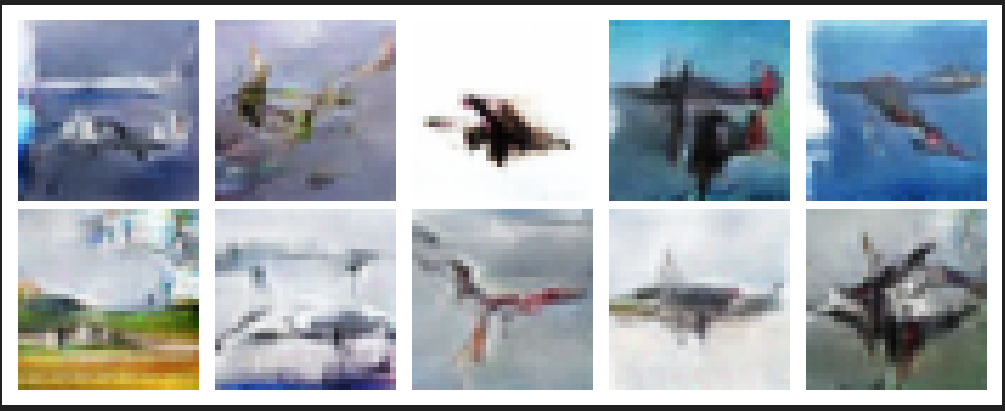

In [ ]:
# Save the model
#gan.set_weights(best_weights)
gan.save("/content/drive/MyDrive/May_2024/Vanilla_3/gan_model.h5")

In [ ]:
# The number of images to generate
num_images = 5

# Generate random noise
noise = np.random.normal(0, 1, (num_images, 100))

# Generate images using the generator
generated_images = generator.predict(noise)

# Visualize the generated images
fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
for i in range(num_images):
    axes[i].imshow(generated_images[i])
    axes[i].axis('off')
plt.show()